In [1]:
#use L-2 MODIS A DATA 
#in accordance with Fang et al. 2018 
#Algorithim for CDOM and DOC that semms good 
import xarray as xr # top library for manipulating netcdf files
import netCDF4 # more basic library for manipulating netcdf files, used for exploring
import glob #to get file names
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import cmocean
import cmocean.cm as cmo
from glob import glob
%matplotlib inline

PART ONE MAPS

In [21]:
#uncomment the file group you want for the maps 

filenames = glob('../../SAT_DATA/NC/GOM21FA_MODIS_Level-2/*OC*.nc')
#filenames = glob('../../SAT_DATA/NC/GOM22SP_MODIS_Level-2/*OC*.nc')
#filenames = glob('../../SAT_DATA/NC/GOM22SU_MODIS_Level-2/*OC*.nc')
filenames.sort()
filenames

['../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211024T180001.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211024T180501.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211024T194001.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T184500.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T202000.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T202500.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211026T192501.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211026T193001.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T183001.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T183501.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T201001.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211028T191500.L2.OC.x.nc',
 '..

In [34]:
#select a file to test 

path = filenames[4]

In [35]:
#make funtion to open file and save attributes 

def load_satdata(path):
    data = xr.open_dataset(path, group='geophysical_data')
    navigation = xr.open_dataset(path, group='navigation_data')
    navigation = navigation.rename({'pixel_control_points': 'pixels_per_line'})
    mask = (~navigation['latitude'].isnull()) & (~navigation['longitude'].isnull())
    data = data.where(mask, drop=True)
    data['lat'] = navigation['latitude'].where(mask, drop=True)
    data['lon'] = navigation['longitude'].where(mask, drop=True)
    atts = xr.open_dataset(path)
    time_start = atts.time_coverage_start
    data.attrs['time_start'] = time_start
    return data

ds = load_satdata(path)
ds

<xarray.Dataset>
Dimensions:   (number_of_lines: 595, pixels_per_line: 202)
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables: (12/22)
    aot_869   (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    angstrom  (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    Rrs_412   (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    Rrs_443   (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    Rrs_469   (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    Rrs_488   (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    ...        ...
    ipar      (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    nflh      (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    par       (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    l2_flags  (number_of_lines, pixels_per_line) float64 1.074e+09 ... 1.074e+09
    lat       (number_of_lines, pixels_per_line) float32 17.45 17.45 ... 22.2
    lon       (number_of_lines, pixels_per_line) float32 -93.52 ... -99.96
Attributes:
    time_start:  2021-10-25T20:20:00.972Z

In [36]:
#make funtion to make the vars we need for maps   

def make_vars(ds):

    #HERE WE CALCUTE CDOM WITH THE ALGORITHUM WITH 
    #Mannino et al. 2015
    
    B0 = 0.2581; B1 = 1.583; B2 = 24.87
    aCDOM275_a = (np.log((ds['Rrs_412']/ds['Rrs_555'] - B0)/ B2))/(-B1)
    aCDOM275_a = aCDOM275_a.compute()
    ds['aCDOM275_a'] = aCDOM275_a
    
    B0 = 0.2452; B1 = 5.576; B2 = 4.838
    aCDOM355_a = (np.log((ds['Rrs_412']/ds['Rrs_555'] - B0)/ B2))/(-B1)
    aCDOM355_a = aCDOM355_a.compute()
    ds['aCDOM355_a'] = aCDOM355_a
    
    B0 = 0.2492; B1 = 8.689; B2 = 4.608
    aCDOM380_a = (np.log((ds['Rrs_412']/ds['Rrs_555'] - B0)/ B2))/(-B1)
    aCDOM380_a = aCDOM380_a.compute()
    ds['aCDOM380_a'] = aCDOM380_a
    
    B0 = 0.2487; B1 = 14.028; B2 = 4.085
    aCDOM412_a = (np.log((ds['Rrs_412']/ds['Rrs_555'] - B0)/ B2))/(-B1)
    aCDOM412_a = aCDOM412_a.compute()
    ds['aCDOM412_a'] = aCDOM412_a
    
    B0 = 0.2479; B1 = 23.40; B2 = 3.770
    aCDOM443_a = (np.log((ds['Rrs_412']/ds['Rrs_555'] - B0)/ B2))/(-B1)
    aCDOM443_a = aCDOM443_a.compute()
    ds['aCDOM443_a'] = aCDOM443_a
    
    B0 = 0.9925; B1 = 2.054; B2 = 634.2
    aCDOM275_b = (np.log((ds['Rrs_412']/ds['Rrs_667'] - B0)/ B2))/(-B1)
    aCDOM275_b = aCDOM275_b.compute()
    ds['aCDOM275_b'] = aCDOM275_b
    
    B0 = 0.8569; B1 = 7.661; B2 = 91.97
    aCDOM355_b = (np.log((ds['Rrs_412']/ds['Rrs_667'] - B0)/ B2))/(-B1)
    aCDOM355_b = aCDOM355_b.compute()
    ds['aCDOM355_b'] = aCDOM355_b
    
    B0 = 0.865; B1 = 11.55; B2 = 79.16
    aCDOM380_b = (np.log((ds['Rrs_412']/ds['Rrs_667'] - B0)/ B2))/(-B1)
    aCDOM380_b = aCDOM380_b.compute()
    ds['aCDOM380_b'] = aCDOM380_b
    
    B0 = 0.8625; B1 = 18.44; B2 = 62.89
    aCDOM412_b = (np.log((ds['Rrs_412']/ds['Rrs_667'] - B0)/ B2))/(-B1)
    aCDOM412_b = aCDOM412_b.compute()
    ds['aCDOM412_b'] = aCDOM412_b
    
    B0 = 0.8502; B1 = 30.53; B2 = 54.78
    aCDOM443_b = (np.log((ds['Rrs_412']/ds['Rrs_667'] - B0)/ B2))/(-B1)
    aCDOM443_b = aCDOM443_b.compute()
    ds['aCDOM443_b'] = aCDOM443_b
    
    #HERE WE CALCUTE CDOM WITH THE ALGORITHUM WITH 
    #Coa et al. 2018
    
    Rss443 = ds['Rrs_443']
    Rss448 = ds['Rrs_488']
    Rss531 = ds['Rrs_531']
    Rss555 = ds['Rrs_555']
    Rss667 = ds['Rrs_667']
    
    #calculate aCDOM 300
    aCDOM300 = (-0.0206*Rss443) + (-0.6128*Rss448) + (-0.0070*Rss531) + (-0.4944*Rss555) + (0.9362*Rss667) + (.9666)
    aCDOM300 = aCDOM300.compute()
    ds['aCDOM300'] = aCDOM300

    #calculate aCDOM 355
    aCDOM355 = (0.0376*Rss443) + (-0.8714*Rss448) +(-0.0352*Rss531) + (-0.2739*Rss555) + (0.9591*Rss667) + (-0.1071)
    aCDOM355 = aCDOM355.compute()
    ds['aCDOM355'] = aCDOM355

    #calculate aCDOM SS 275-295
    aCDOMss = (-0.0537*Rss443) + (0.2689*Rss448) + (0.1017*Rss531) + (-0.2097*Rss555) + (-0.0893*Rss667) + (-3.6853)
    aCDOMss = aCDOMss.compute()
    ds['aCDOMss'] = aCDOMss
    
    #calculate DOC
    #DOC = aCDOM300 / ((np.exp(-15.05-(33.95*aCDOMss)))+(np.exp(-1.502-(104.3*aCDOMss)))) 
    TERM1 = (-15.05-(33.95*aCDOMss))
    TERM2 = (-1.502-(04.3*aCDOMss))
    # np.logaddexp Calculates log(exp(x1) + exp(x2))
    TERM = np.logaddexp(TERM1, TERM2)
    DOC = aCDOM300/(TERM) 
    DOC = DOC.compute()
    ds['DOC'] = DOC

    return ds

ds = make_vars(ds)
ds

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:     (number_of_lines: 595, pixels_per_line: 202)
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables: (12/36)
    aot_869     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    angstrom    (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_412     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_443     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_469     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_488     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    ...          ...
    aCDOM412_b  (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOM443_b  (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOM300    (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOM355    (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOMss     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    DOC         (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
Attributes:
    time_start:  2021-10-25T20:20:00.972Z

In [37]:
#making the map

lat_top=31
lat_bot=25
lon_left=-85
lon_rigth=-95
extent=[lon_left, lon_rigth, lat_bot, lat_top]

def plot_mapbase(extent, res='10m', projection=ccrs.PlateCarree()):
    fig = plt.figure(figsize=(10,5)) # set fig size
    ax = fig.add_subplot(111, projection=projection)
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='grey', # change color here
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue', # change color here
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black'}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    return fig, ax

In [38]:
#making the map

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}
plt.rcParams.update(params)

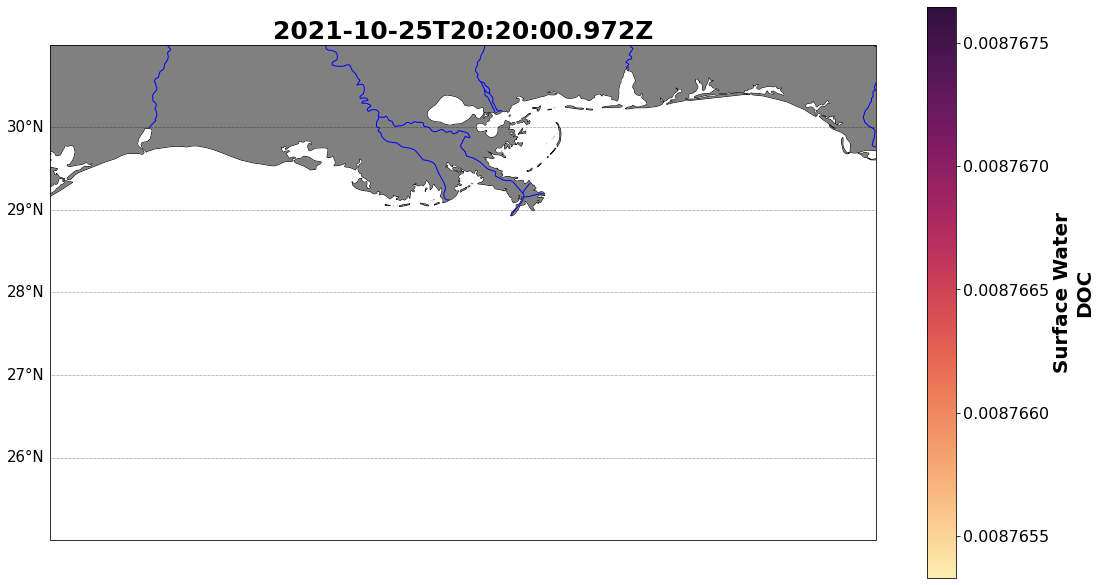

In [39]:
#making the map for the test file 

fig, ax = plot_mapbase(extent)
satdata = ax.pcolormesh(ds['lon'], ds['lat'], ds['DOC'], cmap=cmo.matter, transform=ccrs.PlateCarree())
cb = fig.colorbar(satdata)
cb.ax.tick_params(labelcolor='black') 
cb.set_label('Surface Water\n'+'DOC', size=20, weight='bold', color='black')
tick_font_size = 16
cb.ax.tick_params(labelsize=tick_font_size)
ax.set_title(ds.attrs['time_start'], color='black', size=25, weight='bold',)
fig.set_size_inches(18.5, 10.5)

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  

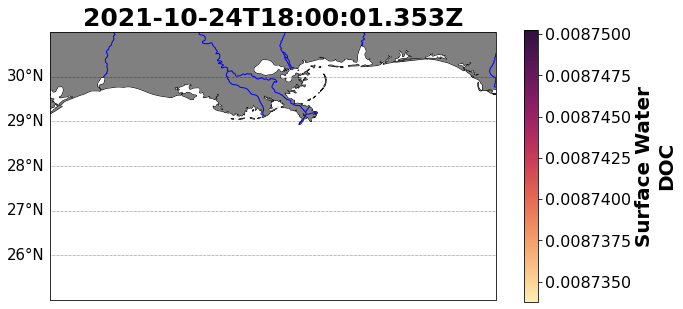

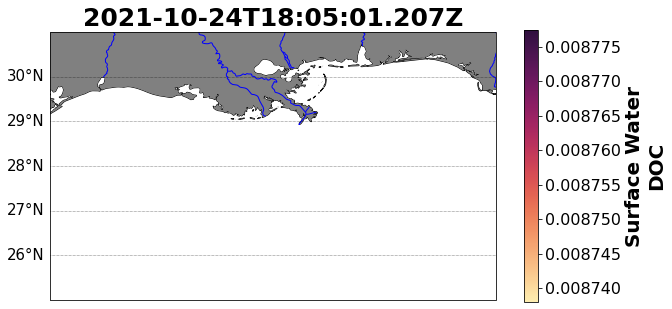

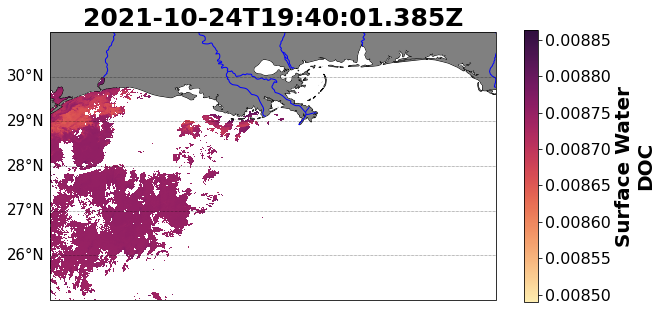

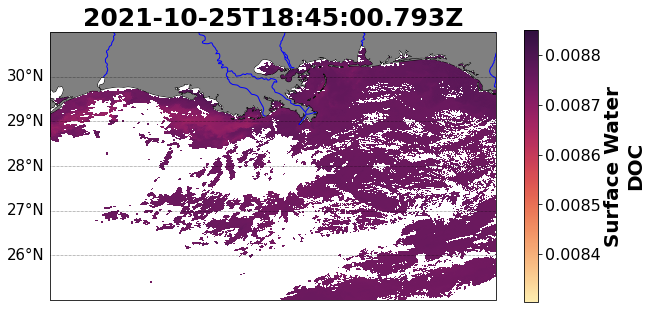

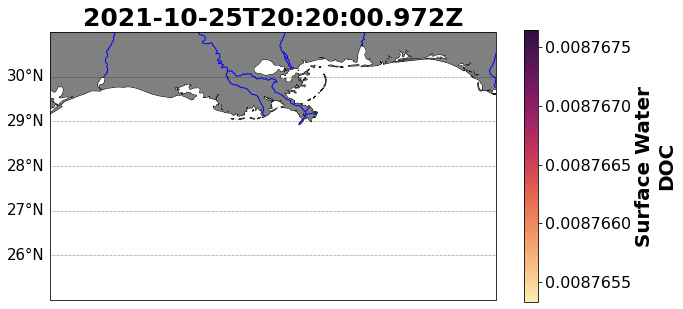

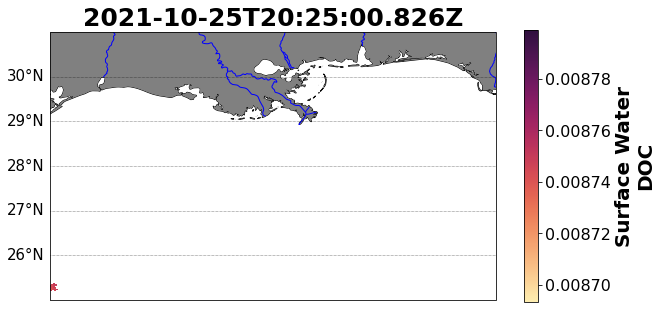

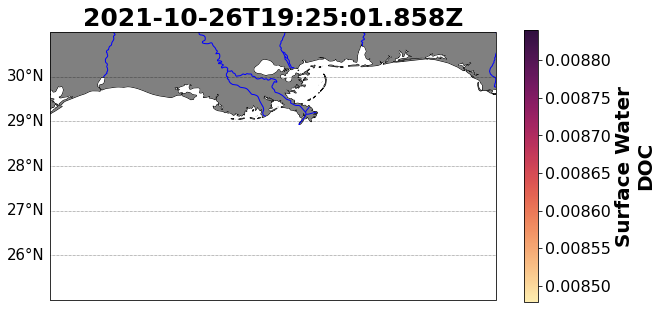

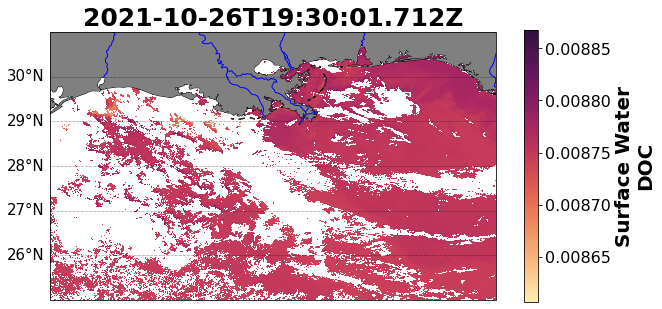

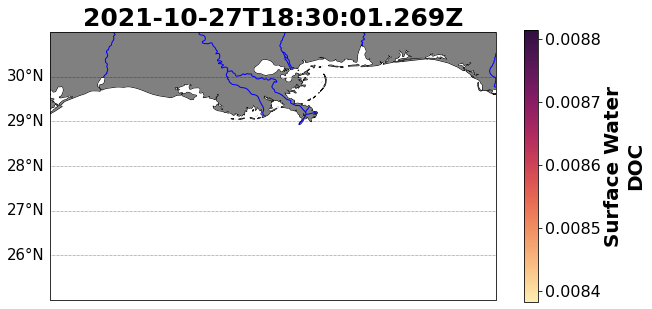

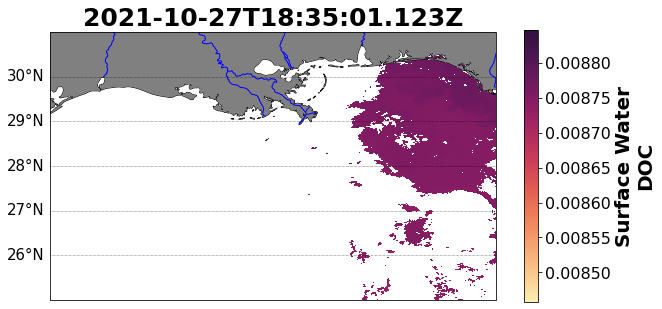

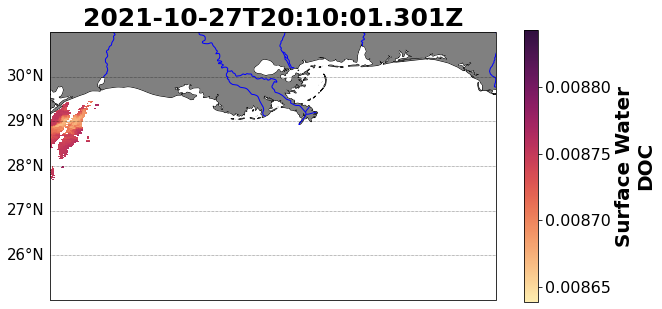

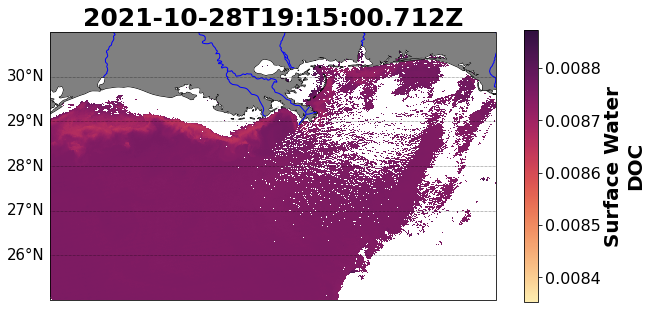

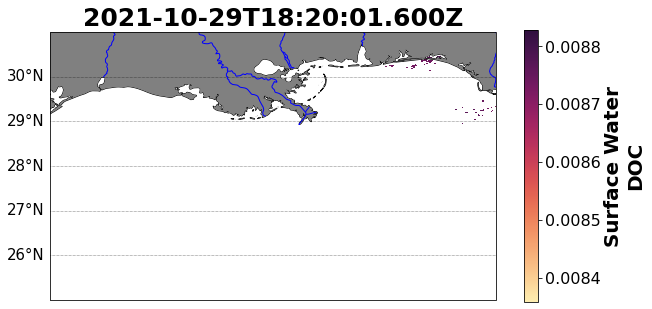

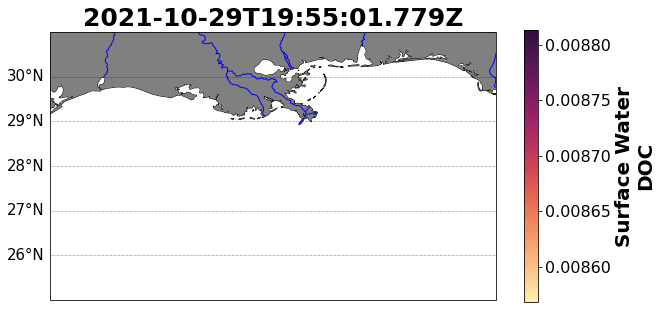

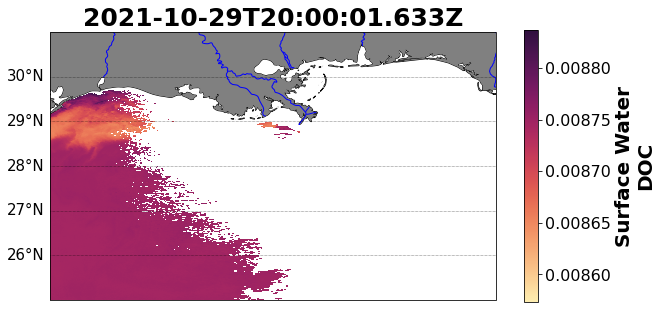

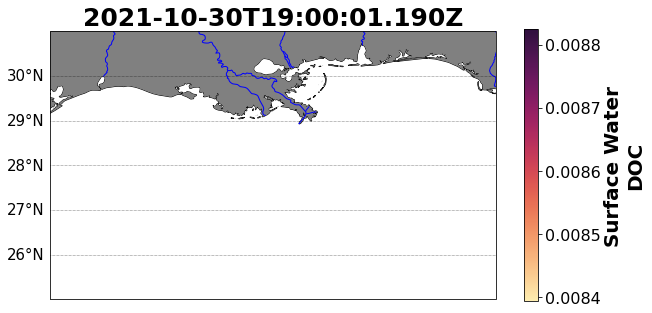

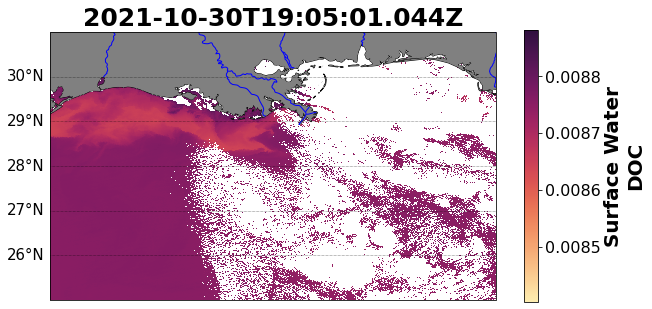

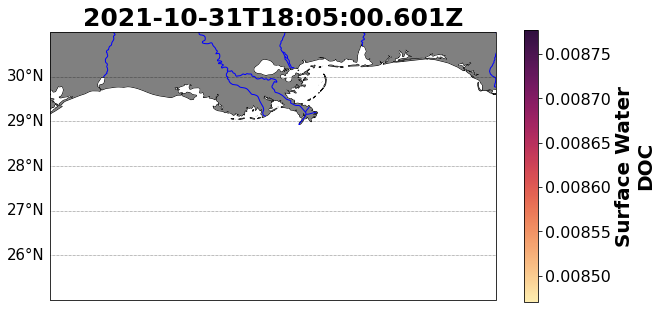

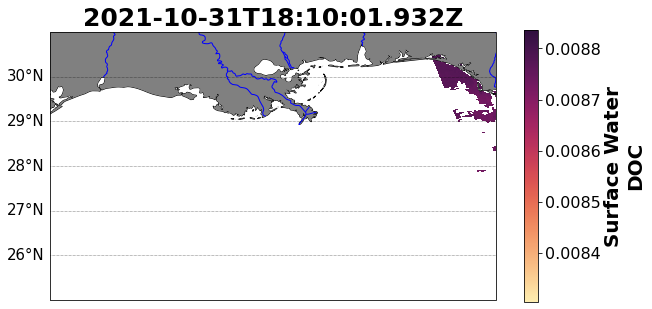

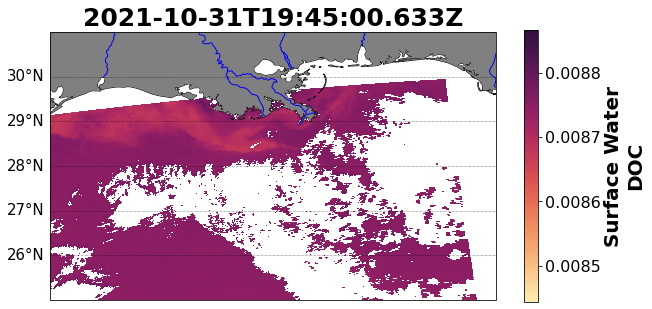

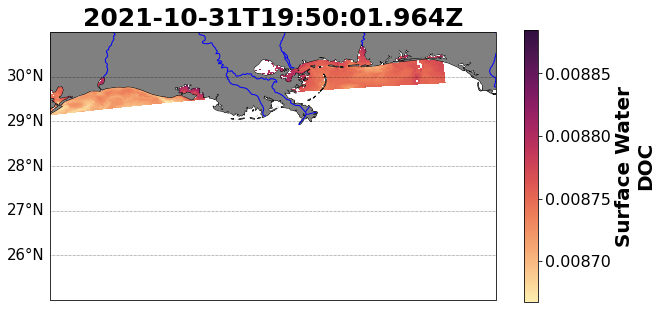

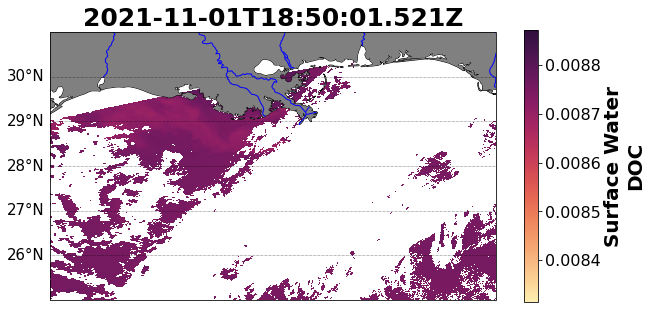

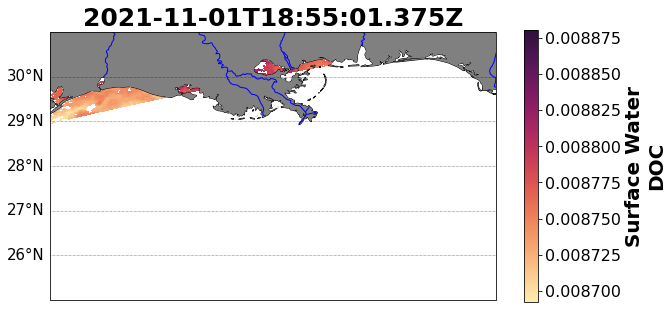

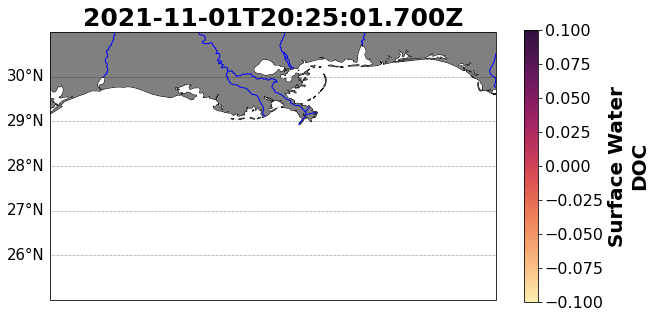

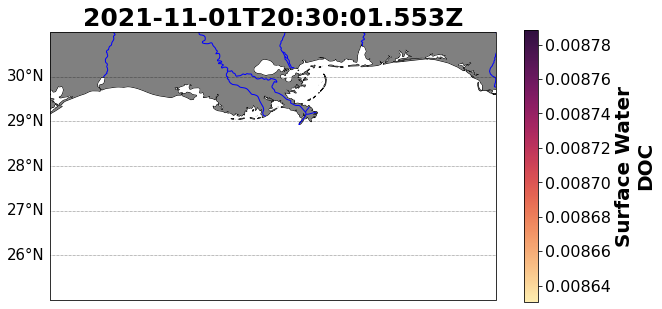

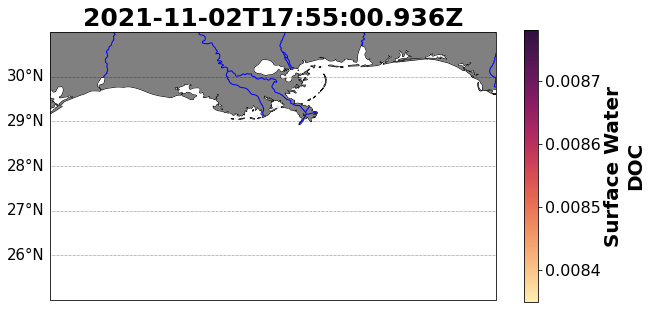

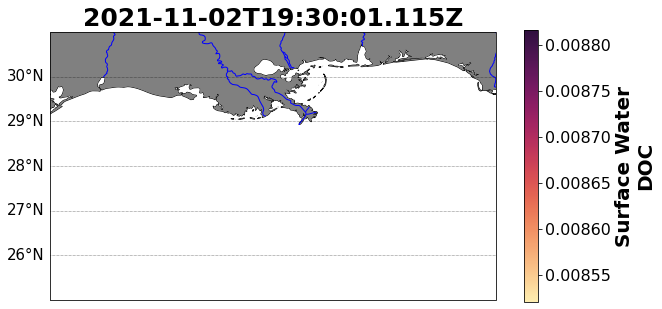

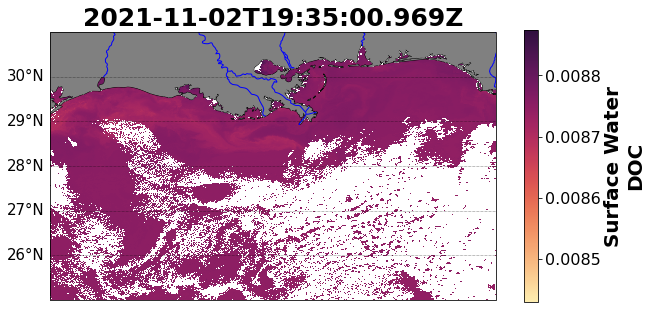

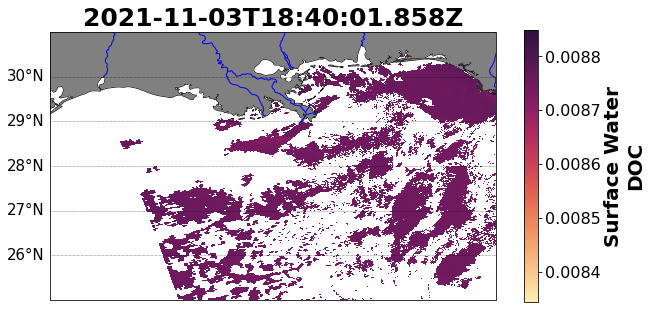

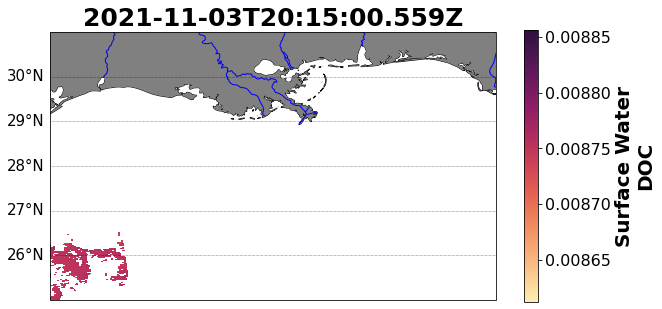

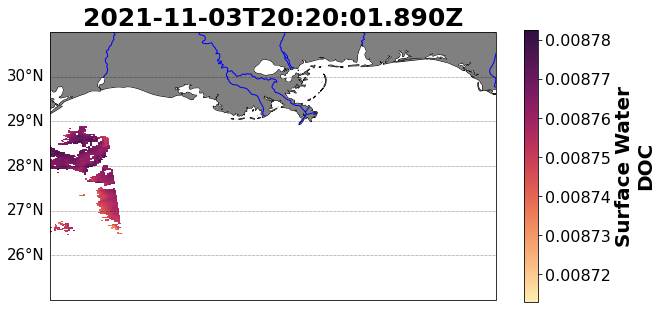

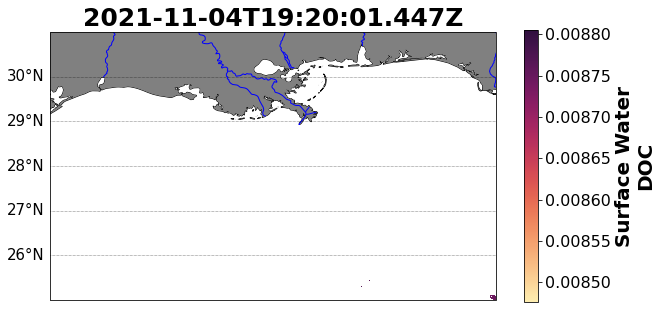

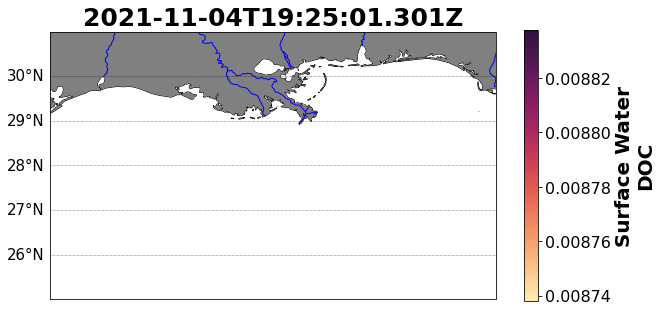

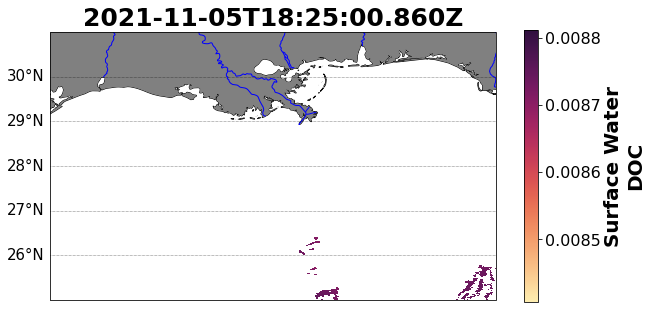

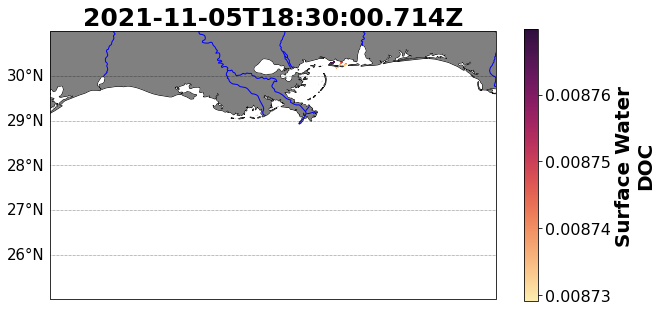

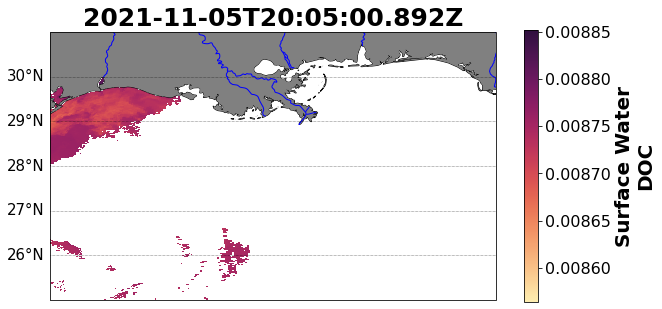

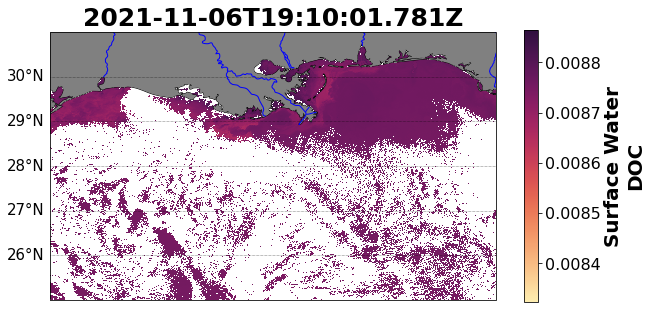

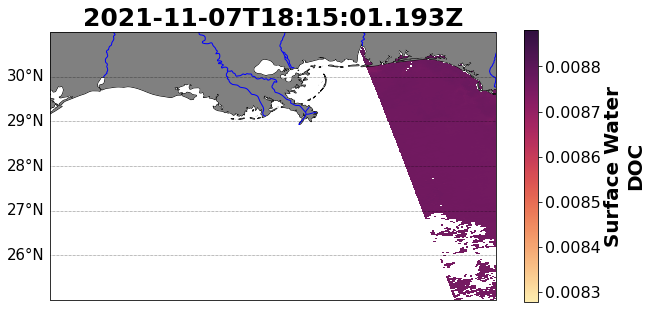

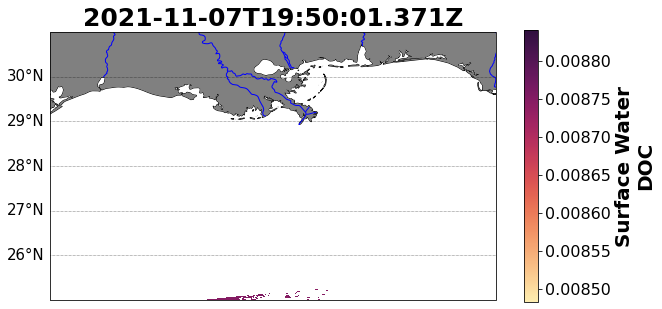

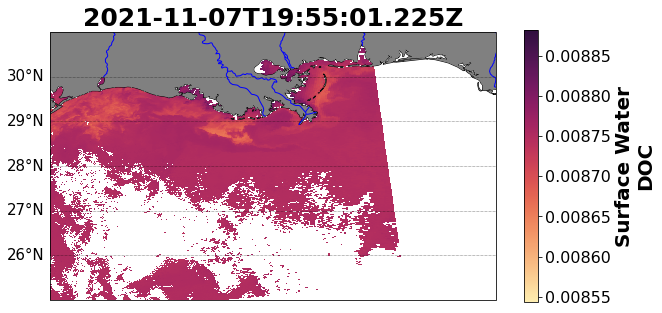

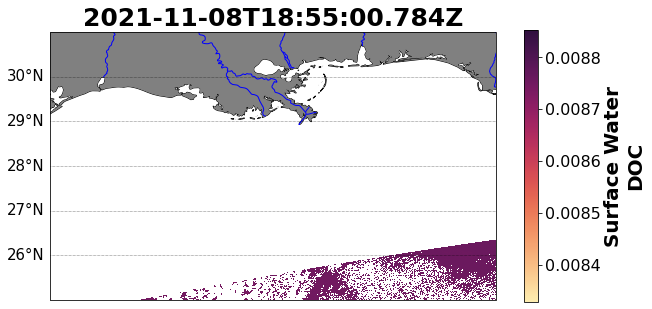

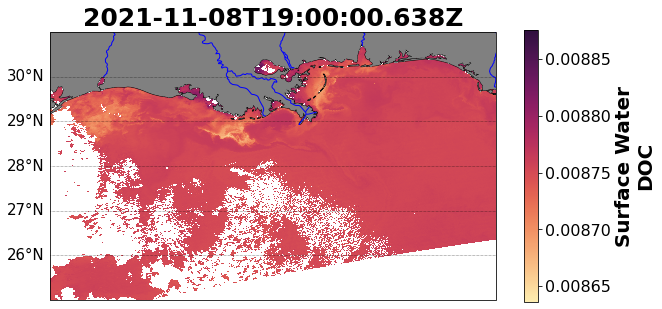

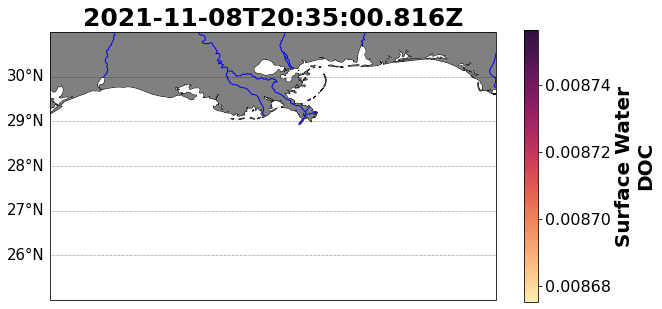

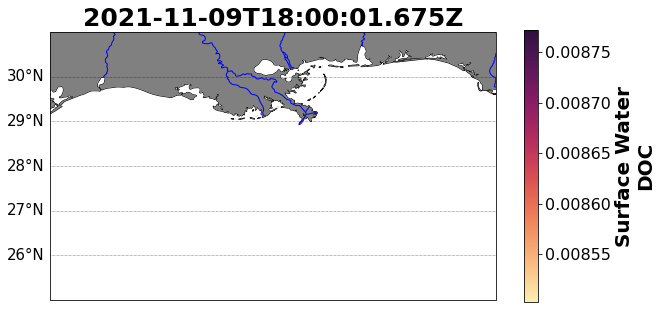

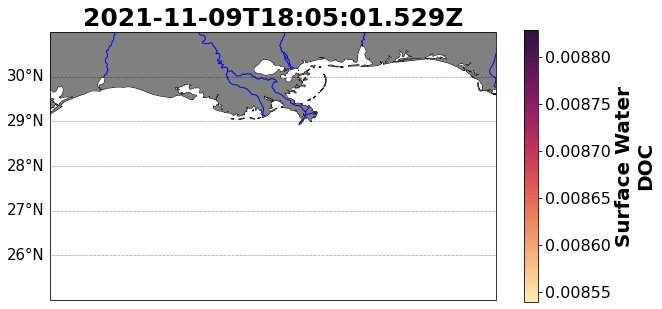

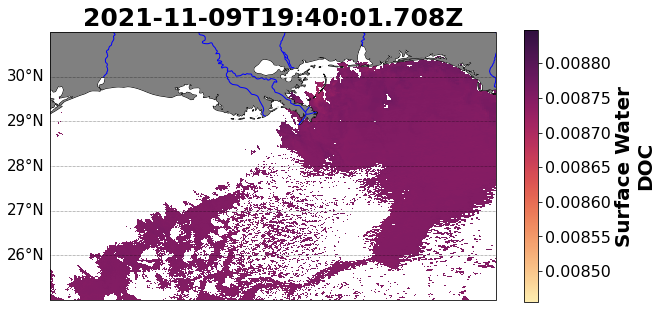

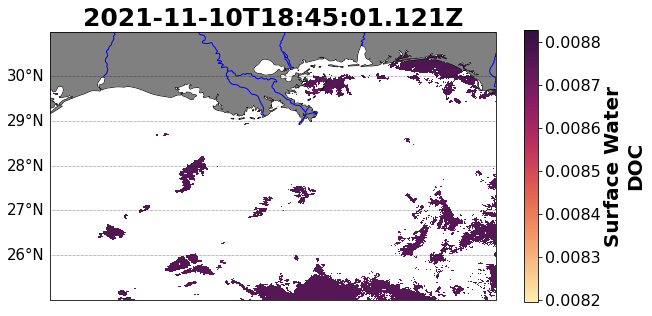

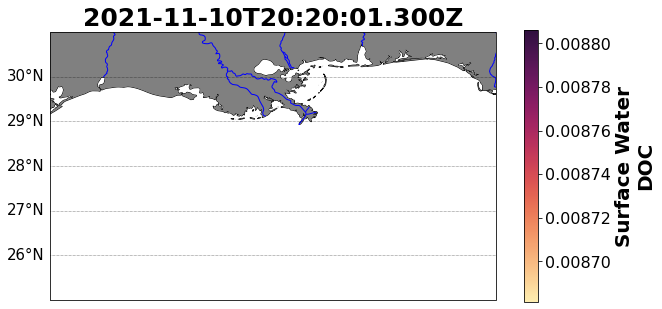

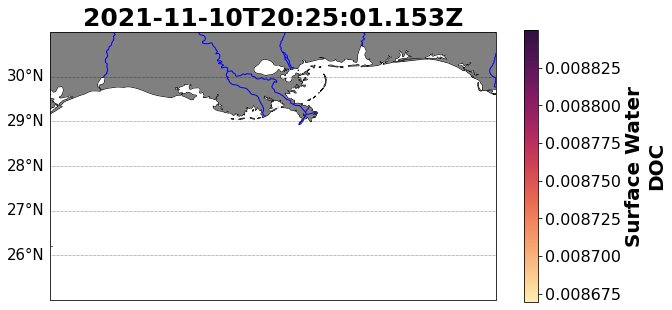

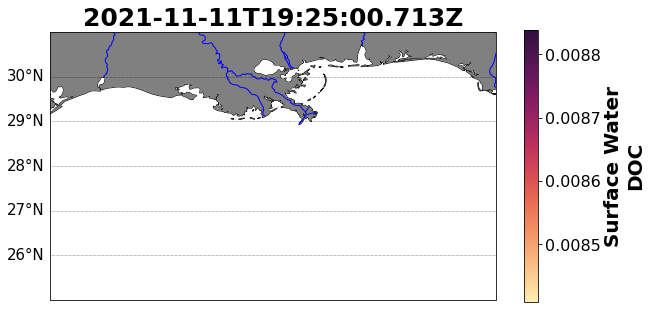

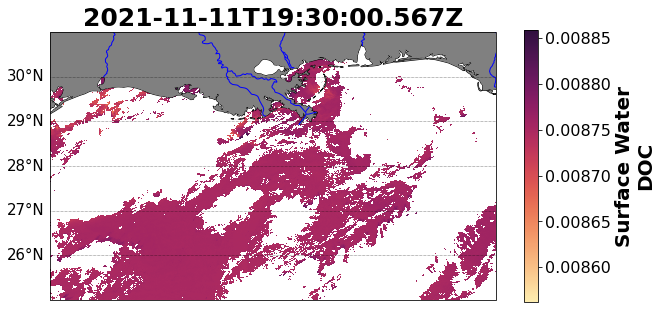

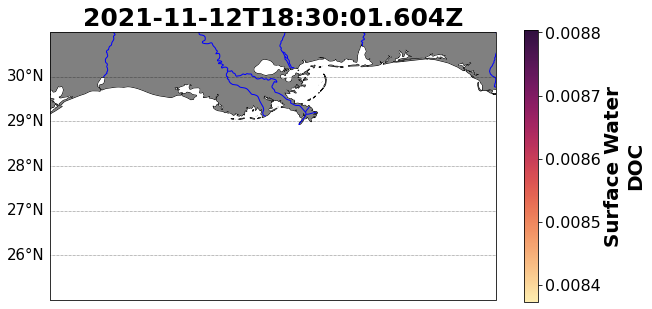

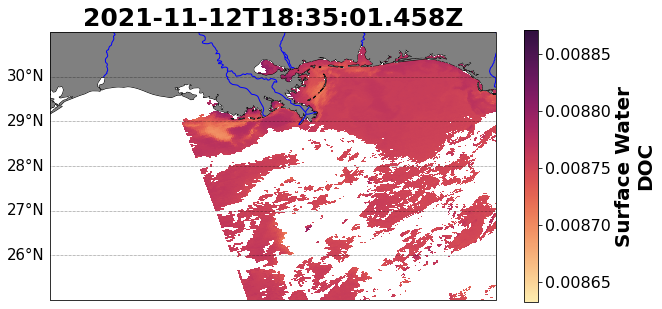

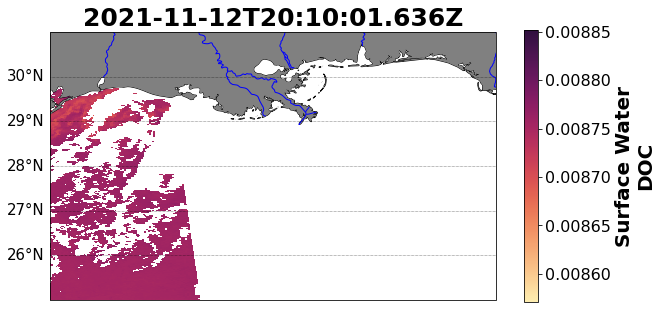

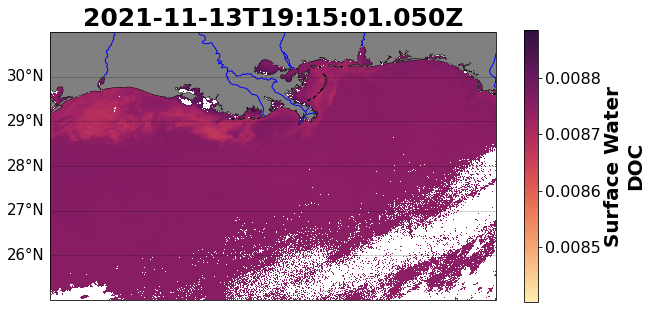

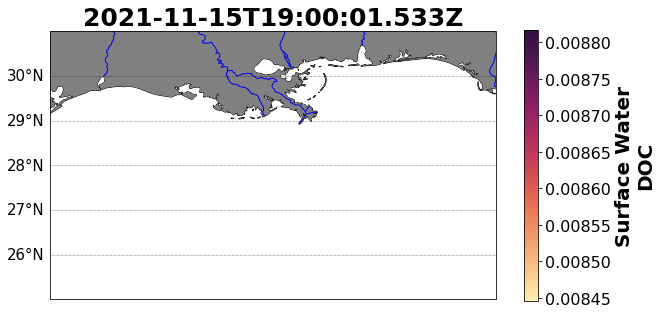

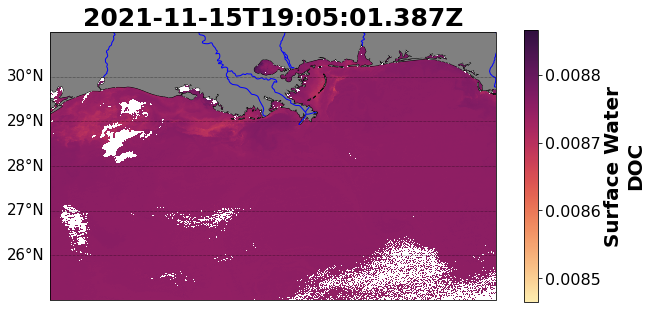

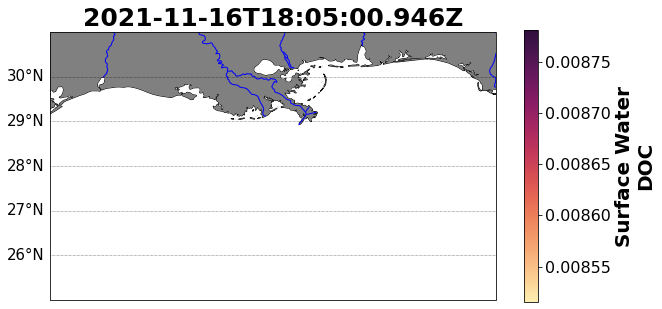

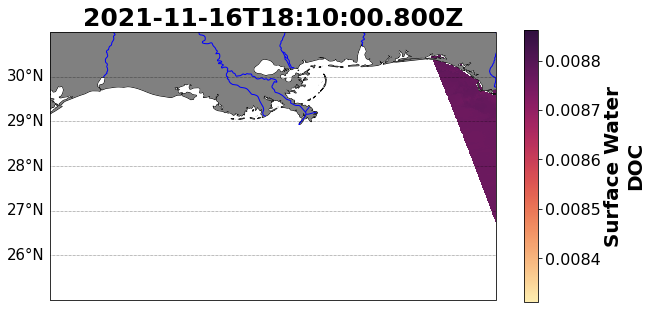

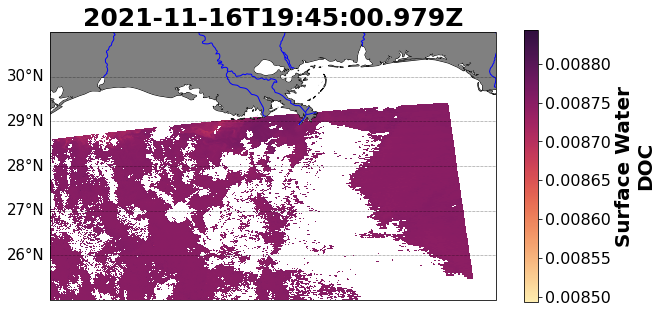

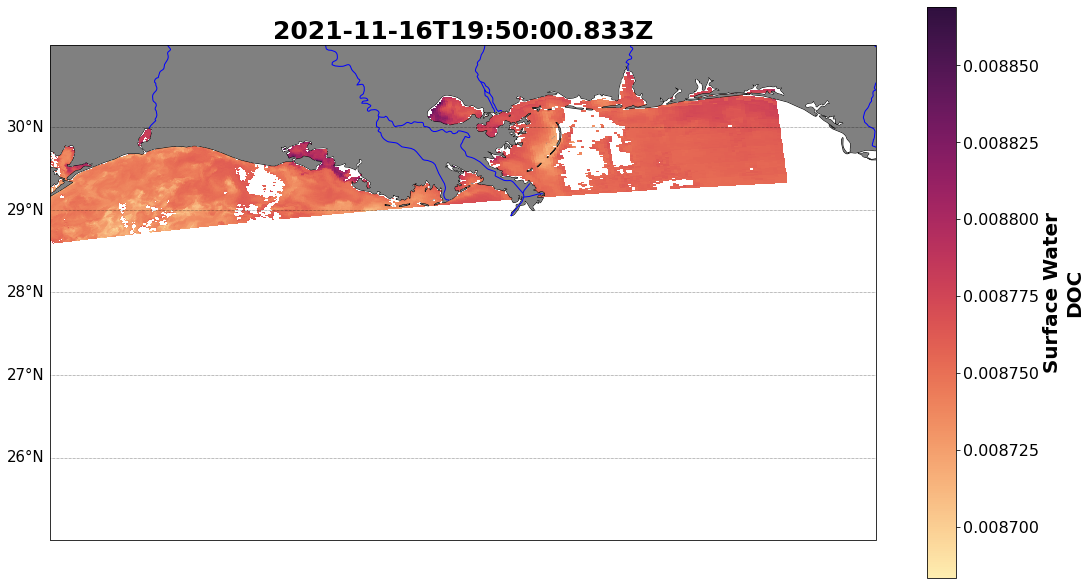

In [40]:
#make a map for all of the files 

for file in filenames: 
    path = file 
    ds = load_satdata(path)
    ds = make_vars(ds)
    fig, ax = plot_mapbase(extent)
    satdata = ax.pcolormesh(ds['lon'], ds['lat'], ds['DOC'], cmap=cmo.matter, transform=ccrs.PlateCarree())
    cb = fig.colorbar(satdata)
    cb.ax.tick_params(labelcolor='black') 
    cb.set_label('Surface Water\n'+'DOC', size=20, weight='bold', color='black')
    tick_font_size = 16
    cb.ax.tick_params(labelsize=tick_font_size)
    ax.set_title(ds.attrs['time_start'], color='black', size=25, weight='bold',)
fig.set_size_inches(18.5, 10.5)

PART 2: DATA TABLES FOR COMPARISON WITH FILD OBSERVATIONS 

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)


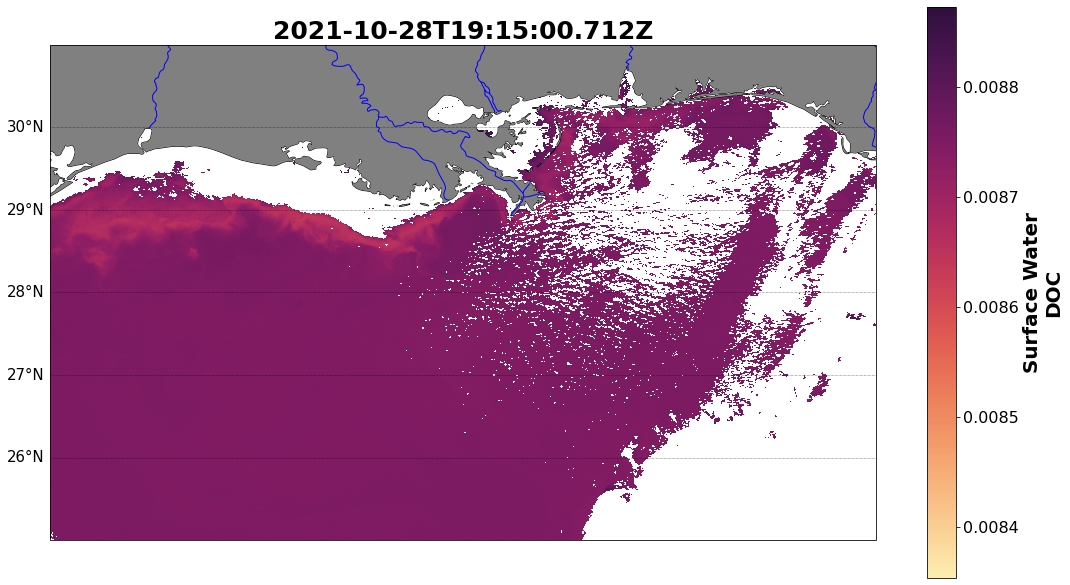

In [49]:
#select a file to test 
path = filenames[11]

#open it and make the DS
ds = load_satdata(path)
ds = make_vars(ds)
ds

#making the map for the test file 
fig, ax = plot_mapbase(extent)
satdata = ax.pcolormesh(ds['lon'], ds['lat'], ds['DOC'], cmap=cmo.matter, transform=ccrs.PlateCarree())
cb = fig.colorbar(satdata)
cb.ax.tick_params(labelcolor='black') 
cb.set_label('Surface Water\n'+'DOC', size=20, weight='bold', color='black')
tick_font_size = 16
cb.ax.tick_params(labelsize=tick_font_size)
ax.set_title(ds.attrs['time_start'], color='black', size=25, weight='bold',)
fig.set_size_inches(18.5, 10.5)

In [80]:
lat_bnds, lon_bnds = [28, 28.1], [-90, -90.1]
xx = ds.sel(ds['lat']==slice(*lat_bnds), ds['lon']==slice(*lon_bnds))

ValueError: the first argument to .sel must be a dictionary

In [76]:
mask = (ds['lat']<28) & (ds['lat']<28.1) & (ds['lon']<-90) & (ds['lon']<-91.1)
data = ds.where(mask)
data

<xarray.Dataset>
Dimensions:     (number_of_lines: 1741, pixels_per_line: 1308)
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables: (12/36)
    aot_869     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    angstrom    (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_412     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_443     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_469     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_488     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    ...          ...
    aCDOM412_b  (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOM443_b  (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOM300    (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOM355    (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOMss     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    DOC         (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
Attributes:
    time_start:  2021-10-28T19:15:00.712Z

In [72]:
latbounds = [ 28 , 28.1 ]
lonbounds = [ -90 , -90.1 ] # degrees east ? 
lats = ds['lat'][:] 
lons = ds['lon'][:]

# latitude lower and upper index
latli = np.argmin( np.abs( lats - latbounds[0] ) )
latui = np.argmin( np.abs( lats - latbounds[1] ) ) 

# longitude lower and upper index
lonli = np.argmin( np.abs( lons - lonbounds[0] ) )
lonui = np.argmin( np.abs( lons - lonbounds[1] ) )  

ValueError: dimensions ('number_of_lines', 'pixels_per_line') must have the same length as the number of data dimensions, ndim=0

In [68]:
#DOC_STXX = ds[(ds['lat']>=28) & (ds['lat']<=28.1)]['DOC']
DOC_STXX = ds['lat']>=28.1
DOC_STXX

<xarray.DataArray 'lat' (number_of_lines: 1741, pixels_per_line: 1308)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Dimensions without coordinates: number_of_lines, pixels_per_line

EXTRA

In [11]:
base = '../../SAT_DATA/NC/OC_APRIL_L2_MODIS_A\\'
swats = np.unique([f.split('\\')[1] for f in filenames])
dayfiles = glob(base+swats[0]+'*')
swats 
#print(dayfiles)

array(['AQUA_MODIS.20220702T191001.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220704T185001.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220704T203500.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220706T202001.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220708T182501.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220708T183001.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220708T200501.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220708T201001.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220709T191501.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220710T182000.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220711T203501.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220711T204001.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220712T180500.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220713T202000.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220713T202500.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220715T183001.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220715T201001.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220717T195501.L2.OC.NRT.x.nc',
       'AQUA_MODIS.20220718T204000.L2.OC.NRT.x.nc',
       'AQUA